# Bert Distillation


## Prepare

### Imports

Torch as baseline for work with models

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

from torchtext.legacy.data import Field

BERT models as base for distillation

In [38]:
from transformers import BertTokenizer, BertModel

Stuff for dataset preparing

In [39]:
import os
import pandas as pd

from sklearn.model_selection import train_test_split

Some fancy features

In [40]:
from tqdm.notebook import tqdm

### Configuration

Parsing config

In [41]:
MAX_VOCAB_SIZE = 10000

Data config

In [42]:
DATA_PATH = './data'
DATASET_FILE_NAME = 'sst2-1000.tsv'
FULL_DATASET_PATH = os.path.join(DATA_PATH, DATASET_FILE_NAME)

In [43]:
FILE_ENCODING = "UTF-8"

In [44]:
X_COLUMN = 'sentence'
Y_COLUMN = 'label'

Models config

In [45]:
USE_CUDA_IF_AVAILABLE = True

### Utils

Parsing utils for vocabulary and special symbols

In [46]:
def get_vocab(X: [str]):
    words = [sentence.split() for sentence in X]
    text_field = Field()
    text_field.build_vocab(words, max_size=MAX_VOCAB_SIZE)
    return text_field

In [47]:
def pad(seq: [str], maxlen: int):
    if len(seq) < maxlen:
        seq = seq + ['<pad>'] * (maxlen - len(seq))
    return seq

In [48]:
def to_indices(vocab, words):
    return [vocab.stoi[w] for w in words]

Tokenizing utils for BERT and LSTM models

In [49]:
def tokenize_bert(X, y, tokenizer: BertTokenizer = None):
    X_split = [t.split() for t in X]
    X_pad = [pad(s, maxlen) for s in X_split]

    lines = [" ".join(s) for s in X_pad]
    masks = [[int(word != '<pad>') for word in sentence] for sentence in X_pad]
    inds = [tokenizer.encode(line.split(), add_special_tokens=False) for line in lines]
    inds = torch.tensor(inds)
    masks = torch.tensor(masks, dtype=torch.int8)
    torch_y = torch.tensor(y, dtype=torch.float)

    return TensorDataset(inds, torch_y, masks)

In [50]:
def tokenize_lstm(X, y, field=None, teacher_output = None):
    X_split = [t.split() for t in X]
    X_pad = [pad(s, maxlen) for s in X_split]

    X_index = [to_indices(field.vocab, s) for s in X_pad]
    torch_x = torch.tensor(X_index, dtype=torch.long)
    torch_y = torch.tensor(y, dtype=torch.float)

    if teacher_output is None:
        return TensorDataset(torch_x, torch_y)
    else:
        return TensorDataset(torch_x, torch_y, teacher_output)

Data processing utils

In [51]:
def read_data(path: str):
    data = pd.read_csv(path, sep='\t')

    X = list(data[X_COLUMN])
    y = list(data[Y_COLUMN])
    maxlen = max([len(x.split()) for x in X])

    return X, y, maxlen

In [52]:
def device():
    return torch.device("cuda" if torch.cuda.is_available() and USE_CUDA_IF_AVAILABLE else "cpu")

Training utils

In [53]:
class DistilLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DistilLoss, self).__init__()
        self.alpha = alpha

    def forward(self, y_pred, y_true, dy_pred, dy_true):
        bce = nn.CrossEntropyLoss()
        mse = nn.MSELoss()

        pred_loss = bce(y_pred, torch.tensor(y_true, dtype=torch.long))
        loss = mse(dy_pred, dy_true)

        return self.alpha * pred_loss + (1 - self.alpha) * loss

## Models

BiLSTM model

In [54]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, bidirectional, dropout, num_layers):
        super(BiLSTM, self).__init__()

        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.LSTM( input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)

        self.pred = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def init_state(self, batch_size):
        zeros = torch.zeros(2 * self.num_layers, batch_size, self.hidden_dim)
        return zeros, zeros

    def forward(self, x):
        x = self.embedding(x)
        x = torch.transpose(x, dim0=1, dim1=0)
        x, hidden = self.rnn(x)

        hidden, cell = hidden
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))

        pred = self.pred(hidden)

        return pred

Simple LSTM model

In [55]:
class SimpleLSTM(nn.Module):
    def __init__(self, lstm: BiLSTM):
        super(SimpleLSTM, self).__init__()
        self.lstm = lstm
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        [indices, labels] = input

        labels = torch.tensor(labels, dtype=torch.long)

        pred = self.lstm(indices)

        loss = self.loss(pred, labels)

        return loss, pred

Simple binary classifier model

In [56]:
class SimpleClassifierModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels=2):
        super(SimpleClassifierModel, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

Distillation baseline model

In [57]:
class BaselineLSTM(nn.Module):
    def __init__(self, teacher, head_hidden_size=128):
        super(BaselineLSTM, self).__init__()
        self.teacher = teacher
        hidden_size = self.teacher.config.hidden_size
        self.classifier = SimpleClassifierModel(hidden_size, head_hidden_size, 2)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input):
        [indices, labels, masks] = input
        labels = torch.tensor(labels, dtype=torch.long)

        output = self.teacher(indices, attention_mask=masks)[0]
        output = output[:, 0, :]

        pred = self.classifier(output)
        loss = self.loss(pred, labels)
        return loss, pred

    def parameters(self, **kwargs):
        return self.classifier.parameters()

Distilled LSTM

In [58]:
class DistilledLSTM(nn.Module):
    def __init__(self, lstm, alpha=0.5):
        super(DistilledLSTM, self).__init__()
        self.lstm = lstm
        self.loss = DistilLoss(alpha)

    def forward(self, inp):
        inds = inp[0]
        labels = inp[1]
        teacher_output = inp[2]
        labels = torch.tensor(labels, dtype=torch.long)
        label_prediction = self.lstm(inds)
        loss = self.loss(label_prediction, labels, label_prediction, teacher_output)
        return loss, label_prediction

## Training

### Parameters

In [59]:
DEFAULT_BATCH_SIZE = 64
DEFAULT_EPOCH_NUMBER = 3

In [60]:
BASE_BERT_MODEL = 'bert-base-uncased'

In [61]:
def train(train_model, dataset, epochs = DEFAULT_EPOCH_NUMBER, batch_size = DEFAULT_BATCH_SIZE, logger = False):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    optimizer = optim.Adam(train_model.parameters())

    train_model = train_model.to(device())
    train_model.train()

    for e in range(epochs):
        losses = 0
        count = 0
        for x_t in tqdm(dataloader):
            x_t = [x_i.to(device()) for x_i in x_t]
            loss, _ = train_model(x_t)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses += loss
            count += 1

        losses /= count

        if logger:
            print(f'Epoch {e} \t: Loss = {losses.item()}')

In [62]:
def test(test_model, dataset, batch_size = DEFAULT_BATCH_SIZE):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    count = 0
    correct = 0

    with torch.no_grad():
      for x_t in tqdm(dataloader):
          x_t = [x_i.to(device()) for x_i in x_t]
          _, y_pred = test_model(x_t)
          y_pred = torch.argmax(y_pred, axis=1)
          correct += torch.sum(y_pred == x_t[1].int())
          count += batch_size

    print(f'Accuracy: {correct / count}')

In [104]:
def evaluate(eval_model, dataset, batch_size):
    eval_model = eval_model.to(device())
    dataloader = DataLoader(dataset, batch_size, shuffle=False)
    y_pred = []
    losses = []

    with torch.no_grad():
      for x_t in tqdm(dataloader):
          x_t = [x_i.to(device()) for x_i in x_t]
          loss, result = eval_model(x_t)
          y_pred.append(result)
          losses.append(loss)
      y_pred = torch.cat(y_pred)

    return losses, y_pred

### Data preprocessing

In [64]:
X, y, maxlen = read_data(FULL_DATASET_PATH)

In [65]:
field = get_vocab(X)

In [66]:
vocab_size = len(field.vocab.stoi.keys())

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

### Preparing models

Bert initializing

In [68]:
bert_tokenizer = BertTokenizer.from_pretrained(BASE_BERT_MODEL)
bert = BertModel.from_pretrained(BASE_BERT_MODEL)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training Process

Baseline LSTM model initializing

In [69]:
BASELINE_MODEL_EPOCHS = 3
BASELINE_MODEL_BATCH_SIZE = 16

In [70]:
baseline_lstm = BaselineLSTM(bert)

In [71]:
base_train = tokenize_bert(X_train, y_train, tokenizer=bert_tokenizer)
base_test = tokenize_bert(X_test, y_test, tokenizer=bert_tokenizer)

Baseline LSTM model training

In [72]:
train(baseline_lstm, base_train, epochs=BASELINE_MODEL_EPOCHS, batch_size=BASELINE_MODEL_BATCH_SIZE, logger=True)

  0%|          | 0/127 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Epoch 0 	: Loss = 0.6914628744125366


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1 	: Loss = 0.6752426624298096


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2 	: Loss = 0.6592393517494202


#### Distillation

Base model initialization

In [73]:
BASE_MODEL_EMBEDDING_DIM = 16
BASE_MODEL_HIDDEN_DIM = 16
BASE_MODEL_OUTPUT_DIM = 2
BASE_MODEL_DPOPOUT = 0.5
BASE_MODEL_NUM_LAYERS = 1

In [74]:
base_model = BiLSTM(input_dim=vocab_size, embedding_dim=BASE_MODEL_EMBEDDING_DIM, hidden_dim=BASE_MODEL_HIDDEN_DIM, output_dim=BASE_MODEL_OUTPUT_DIM, bidirectional=True, dropout=BASE_MODEL_DPOPOUT, num_layers=BASE_MODEL_NUM_LAYERS)

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\torch\nn\modules\rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Simple model initialization

In [75]:
SIMPLE_MODEL_EPOCHS = 3
SIMPLE_MODEL_BATCH_SIZE = 16

In [76]:
simple_model = SimpleLSTM(base_model)

Simple model training

In [77]:
simple_train = tokenize_lstm(X_train, y_train, field=field)

In [78]:
train(simple_model, simple_train, epochs=SIMPLE_MODEL_EPOCHS, batch_size=SIMPLE_MODEL_BATCH_SIZE, logger=True)

  0%|          | 0/127 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Epoch 0 	: Loss = 0.6954060792922974


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1 	: Loss = 0.6884639859199524


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2 	: Loss = 0.6729574203491211


Distillation model initialization

In [79]:
DISTIL_MODEL_EMBEDDING_DIM = 16
DISTIL_MODEL_HIDDEN_DIM = 16
DISTIL_MODEL_OUTPUT_DIM = 2
DISTIL_MODEL_DROPOUT = 0.5
DISTIL_MODEL_NUM_LAYERS = 1

In [80]:
_, baseline_output_train = evaluate(baseline_lstm, base_train, batch_size=32)
_, baseline_output_test = evaluate(baseline_lstm, base_test, batch_size=32)

  0%|          | 0/64 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/16 [00:00<?, ?it/s]

In [81]:
distil_train = tokenize_lstm(X_train, y_train, teacher_output=baseline_output_train, field=field)

In [82]:
distil_model = BiLSTM(input_dim=vocab_size, embedding_dim=DISTIL_MODEL_EMBEDDING_DIM, hidden_dim=DISTIL_MODEL_HIDDEN_DIM, output_dim=DISTIL_MODEL_OUTPUT_DIM, bidirectional=True, dropout=DISTIL_MODEL_DROPOUT, num_layers=DISTIL_MODEL_NUM_LAYERS)

Distilled model

In [83]:
DISTILLED_MODEL_ALPHA = 0.5
DISTILLED_MODEL_EPOCHS = 3
DISTILLED_MODEL_BATCH_SIZE = 16

In [84]:
distilled_model = DistilledLSTM(distil_model, alpha=DISTILLED_MODEL_ALPHA)

In [85]:
train(distilled_model, distil_train, epochs=DISTILLED_MODEL_EPOCHS, batch_size=DISTILLED_MODEL_BATCH_SIZE, logger=True)

  0%|          | 0/127 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Epoch 0 	: Loss = 0.3915472626686096


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 1 	: Loss = 0.3814343810081482


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch 2 	: Loss = 0.3782539963722229


### Test

In [86]:
simple_test = tokenize_lstm(X_test, y_test, field=field)
test(simple_model, simple_test, SIMPLE_MODEL_BATCH_SIZE)

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy: 0.603515625


d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [87]:
test(baseline_lstm, base_test, BASELINE_MODEL_BATCH_SIZE)

  0%|          | 0/32 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Accuracy: 0.556640625


In [88]:
distil_test = tokenize_lstm(X_test, y_test, teacher_output=baseline_output_test, field=field)
test(distilled_model, distil_test, DISTILLED_MODEL_BATCH_SIZE)

  0%|          | 0/32 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Accuracy: 0.54296875


In [105]:
simple_losses, _ = evaluate(simple_model, simple_test, SIMPLE_MODEL_BATCH_SIZE)
baseline_losses, _ = evaluate(baseline_lstm, base_test, BASELINE_MODEL_BATCH_SIZE)
distil_losses,_ = evaluate(distilled_model, distil_test, DISTILLED_MODEL_BATCH_SIZE)

  0%|          | 0/32 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/32 [00:00<?, ?it/s]

d:\github\b-o-o-p\itmo-dl\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/32 [00:00<?, ?it/s]

In [106]:
import matplotlib.pyplot as plt

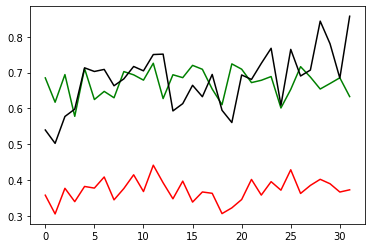

In [107]:
n = range(len(simple_losses))

plt.plot(n, simple_losses, 'g', n, baseline_losses, 'k', n, distil_losses, 'r')